In [3]:
# export
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.regularizers import l2
from pathlib import Path

## `Parameters`

In [4]:
! cat darknet/cfg/yolov3.cfg

[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=64
subdivisions=16
width=608
height=608
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutiona

In [5]:
# export
INPUT_SIZE = 416

ANCHORS = np.array([(10,13),(16,30),(33,23),(30,61),(62,45),(59,119),(116,90),(156,198),(373,326)],
                   np.float32)

ANCHORS = ANCHORS/INPUT_SIZE

MASK = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])
MAX_BOXES = 100

IOU_THRES = 0.5
SCORE_THRES = 0.5
DECAY = 0.0005
MOMENTUM = 0.9
CHANNELS = 3
NUM_CLASSES = 80


WEIGHT_FILE = "../DeepLearning/Computer-Vision/CVND_Exercises/2_2_YOLO/cfg/yolov3.weights"
OUTPUT_DIR = Path("outputs/")

## `Darknet Utils:`

In [6]:
# export
def darknet_conv(x, filters, kernel_size, strides=1, bnorm=True):
    """
    Creates a Standard Darknet Layer: 
    inp => Conv => BatchNorm[Optional] => LeakyReLU[Optional]
    """
    if strides == 1:    padding = "same"
    else:
        x = keras.layers.ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
        
    x = keras.layers.Conv2D(
        filters=filters, kernel_size=kernel_size,
        strides=strides, padding=padding,
        use_bias=not bnorm, kernel_regularizer=l2(DECAY))(x)
    
    if bnorm:
        x = keras.layers.BatchNormalization(momentum=MOMENTUM)(x)
        x = keras.layers.LeakyReLU(alpha=0.1)(x)
        
    return x

In [7]:
# export
def darknet_residual(x, filters):
    """
    Creates a Standard DarkNet Residual Connection
    inp => darknet_conv => darknet_conv => Add[inp, darknet_conv]
    """
    prev = x
    x = darknet_conv(x, filters//2, kernel_size=1)
    x = darknet_conv(x, filters,    kernel_size=3)
    x = keras.layers.Add()([prev, x])
    return x

In [8]:
# export
def darknet_block(x, filters, nums):
    """
    Creates a Standard Darknet Block
    inp => darknet_conv => nums x darknet_residual
    """
    x = darknet_conv(x, filters, kernel_size=3, strides=2)
    for _ in range(nums):
        x = darknet_residual(x, filters)
    return x

## `Darknet_53`:

In [9]:
# export
def Darknet_53(size=INPUT_SIZE, channels=CHANNELS, **kwargs):
    """
    Creates the Darknet_53 Module
    """
    x = inputs = keras.Input([size, size, channels])
    x = darknet_conv(inputs, 32, kernel_size=3)
    x = darknet_block(x, 64, nums=1)
    x = darknet_block(x, 128, nums=2)
    x = route_1 = darknet_block(x, 256, nums=8)
    x = route_2 = darknet_block(x, 512, nums=8)
    x = route_3 = darknet_block(x, 1024, nums=4)
    return keras.Model(inputs, outputs=(route_1, route_2, route_3), **kwargs)

## `YOLO Utils`:

In [10]:
# export
def yolo_layer(filters, name=None):
    def output(x_in):
        """
        Wrapper for 5 
        Darknet_conv layers in succession with :
           filters = [filters, filters*2, filters, filters*2, filters] 
                 & 
           kernel_size  = [1, 3, 1, 3, 1]
        """
        if isinstance(x_in, tuple):
            # if not the first output skip connection
            inputs = keras.Input(x_in[0].shape[1:]), keras.Input(x_in[1].shape[1:])
            x, x_skip = inputs
            # concat with skip connection
            x = darknet_conv(x, filters, 1)
            x = keras.layers.UpSampling2D(2, interpolation="bilinear")(x)
            x = keras.layers.Concatenate()([x, x_skip])
        else:
            # no skip connection for the first output
            x = inputs = keras.Input(x_in.shape[1:])
        x = darknet_conv(x, filters, 1)
        x = darknet_conv(x, filters * 2, 3)
        x = darknet_conv(x, filters, 1)
        x = darknet_conv(x, filters * 2, 3)
        x = darknet_conv(x, filters, 1)
        return keras.Model(inputs, x, name=name)(x_in)
    return output

In [11]:
# export
def yolo_output_layer(filters, num_anchors, num_classes, name=None):
    def output(x_in):
        """
        Processes & reshapes outputs into:
        [batch_size, grid_size, grid_size, num_anchors, (num_classes+5)]
        """
        x = inputs = keras.Input(x_in.shape[1:])
        x = darknet_conv(x, filters * 2, 3)
        x = darknet_conv(x, num_anchors*(num_classes+5), 1, bnorm=False)
        # Reshape into required output shape
        x = keras.layers.Lambda(
            lambda x: tf.reshape(x, shape=(-1, tf.shape(x)[1], tf.shape(x)[2], num_anchors, num_classes+5))
        )(x)
        
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return output

## `YOLO_V3`:

In [12]:
# export
def YOLO(size=INPUT_SIZE, channels=CHANNELS, anchors=ANCHORS, mask=MASK, num_classes=NUM_CLASSES):
    """
    Creates a YOLO_V3 Model
    """
    x = inputs = keras.Input([size, size, channels], name="INPUT-416x416x3")
    # Feature extractor : Darknet_53
    route_1, route_2, x = Darknet_53(name="DARKNET-53")(x)
    
    # darknet_conv => output_1
    x = yolo_layer(filters=512, name="YOLO_LAYER_0")(x)
    output_0 = yolo_output_layer(512, len(mask[0]), num_classes, "YOLO_OUTPUT_0")(x)
    
    # skip connection => datknet_conv => output_2
    x = yolo_layer(256, name="YOLO_LAYER_1")((x, route_2))
    output_1 = yolo_output_layer(256, len(mask[1]), num_classes, "YOLO_OUTPUT_1")(x)
    
    # skip connection => datknet_conv => output_3
    x = yolo_layer(128, name="YOLO_LAYER_2")((x, route_1))
    output_2 = yolo_output_layer(128, len(mask[2]), num_classes, "YOLO_OUTPUT_2")(x)
    
    return keras.Model(inputs, outputs=(output_0, output_1, output_2), name="YOLO_V3")

## `Prediction Utils`:

In [13]:
# export
def cvt_boxes(pred, t_xy, t_wh, anchors):
    """
    Arguments: t_xy, t_wh, anchors
    """
    # Calculate the grid_size
    grid_size = tf.shape(pred)[1:3]
    
    # create grid offsets
    grid = tf.meshgrid(tf.range(grid_size[1]), tf.range(grid_size[0]))
    # out: (grid_size,grid_size),(grid_size,grid_size)
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
    # out: (grid_size, grid_size, 2) -> (grid_size, grid_size, 1, 2)
    
    # sigmoid and add offset & scale with achors
    ## Normalize
    box_xy = (tf.sigmoid(t_xy) + tf.cast(grid, tf.float32))/ tf.cast(grid_size, tf.float32)
    wh = tf.exp(t_wh) * anchors
     
    # [x1, y1, x2, y2]: Normalized
    box_x1y1 = box_xy - wh / 2
    box_x2y2 = box_xy + wh / 2
    
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
    return bbox

In [14]:
# export
def decode_preds(preds, anchors, num_classes=NUM_CLASSES, inp_dim=INPUT_SIZE):
    """
    Decode Final Layer Predicitons from YOLO Model
    """
    # preds: [batch_size, grid, grid, num_anchors, x, y, w, h, obj, classes ...]
    # Grab t_xy, t_wh, objectness, class_probs from the given predictions
    t_xy, t_wh, objectness, class_probs = tf.split(preds, (2, 2, 1, num_classes), axis=-1)
    
    # Calcualte objectness and class probs
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    bbox = cvt_boxes(preds, t_xy, t_wh, anchors)
    
    # concat: shape[batch_size, grid_size, grid_size, num_anchors, (5+num_classes)]
    outputs = tf.concat([bbox, objectness, class_probs], axis=-1)
    
    return outputs

In [15]:
# export
def nms(outputs, max_boxes=MAX_BOXES, iou_threshold=IOU_THRES, score_threshold=SCORE_THRES):
    """
    Computes Non-Max Supression
    """
    boxes, conf, probs = [], [], []
    
    # extract values from the outputs
    # outputs: [3,batch_size,grid_size,grid_size,anchors,(Normalized:[x1,y1,x2,y2]+ojectness+num_classes)]
    for o in outputs:
        boxes.append(tf.reshape(o[...,0:4], (tf.shape(o[...,0:4])[0], -1, tf.shape(o[...,0:4])[-1])))
        conf.append(tf.reshape(o[...,4:5], (tf.shape(o[...,4:5])[0], -1, tf.shape(o[...,4:5])[-1])))
        probs.append(tf.reshape(o[...,5:], (tf.shape(o[...,5:])[0], -1, tf.shape(o[...,5:])[-1])))
    
    bbox = tf.concat(boxes, axis=1) # [..., 4] 
    confidence = tf.concat(conf, axis=1) # [..., 1]
    class_probs = tf.concat(probs, axis=1) # [..., num_classes]
    #print(bbox.shape, confidence.shape, class_probs.shape)
    
    # calculate the scores
    scores = confidence * class_probs
    
    # Compute Non-Max Supression
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        # [batch_size, num_boxes, num_classes, 4]
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        # [batch_size, num_boxes, num_classes]
        scores=tf.reshape(scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])), 
        max_output_size_per_class=max_boxes,
        max_total_size=max_boxes,
        iou_threshold=iou_threshold,
        score_threshold=score_threshold)
    
    # shapes: [batch_size, max_boxes, 4], [batch_size, max_boxes], ..., [batch_size]
    return boxes , scores, classes, valid_detections

## `Load weights` Function:

In [16]:
# export

YOLOV3_LAYER_LIST = [
   'DARKNET-53',
   'YOLO_LAYER_0',
   'YOLO_OUTPUT_0',
   'YOLO_LAYER_1',
   'YOLO_OUTPUT_1',
   'YOLO_LAYER_2',
   'YOLO_OUTPUT_2']

In [17]:
# export
import os
import logging

def load_weights(model, weights_file, layers):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
    
    counter = 1
    
    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.get_input_shape_at(0)[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)
                
        percent_comp = (counter / len(layers)) * 100
        
        print('[INFO] Loading weights. Please Wait...{:.2f}% Complete'.format(percent_comp),
              end = '\r', flush = True)
        counter += 1
    
    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()
    print("\n[INFO] Weights Loaded Successfully ... ")

## `YOLO` CLass

In [18]:
#export
class YOLO_V3(keras.Model):
    """
    Creates a keras.Model instnace for YOLO_V3
    
    Arguments:
        1. size = Integer (size of the input image)
                  [default=416]
        2. channels = Integer (no of input channels)
                      [default = 3]
        3. num_classes = Integer (no. of output_classes)
                         [default=3]
        4. anchors = Array (YOLO anchors) [default = cfg file anchors]
        5. mask = Array (YOLO Mask) [default = cfg file mask]
    """
    def __init__(self,
                 size=INPUT_SIZE,
                 channels=CHANNELS,
                 num_classes=NUM_CLASSES,
                 anchors=ANCHORS,
                 mask = MASK):
        
        super(YOLO_V3, self).__init__()
        self.yolo_V3 = YOLO(size, channels, anchors, mask, num_classes)
        self.anchors = anchors
        self.mask = mask
        self.classes = num_classes
        self.layer_list = YOLOV3_LAYER_LIST
        
    def call(self, inputs,training=False):
        return self.yolo_V3(inputs,training=training)
    
    def load_darknet_weights(self, pth=WEIGHT_FILE):
        """
        Loads the Darknet Model Weights
        Arguments:
        ---------
            1. Path to the darknet weight file
        """
        load_weights(self.yolo_V3, pth, self.layer_list)
        
    def predict(self, x, 
                max_boxes=MAX_BOXES,
                iou_threshold=IOU_THRES,
                score_threshold=SCORE_THRES,
                verbose=0):
        """
        Predicts bounding_boxes, scores & number of objects detected
        
        Arguments:
           1. x = Tensor or Array([batch_size,size,size,channels])[input image]
           2. max_boxes = Integer [Maximum number of boxes to detect in 1 image]
                          (default=100)
           3. iou_threshold = Float [IOU threshold for detecting boxes]
                              (default=0.5)
           4. score_threshold = Float [SCORE threshold for filtering boxes]
                                (default=0.5)
           5. verbose = Verbosity (default=0)
        """
        super(YOLO_V3, self).predict(x=x, verbose=verbose)
        outputs = self(x, training=False)
        output_0, output_1, output_2 = outputs
        
        preds_0 = keras.layers.Lambda(
            lambda x: decode_preds(x,self.anchors[self.mask[0]], self.classes))((output_0))
        
        preds_1 = keras.layers.Lambda(
            lambda x: decode_preds(x,self.anchors[self.mask[1]], self.classes))((output_1))
        
        preds_2 = keras.layers.Lambda(
            lambda x: decode_preds(x,self.anchors[self.mask[2]], self.classes))((output_2))
        
        outputs = keras.layers.Lambda(
            lambda x: nms(x, max_boxes, iou_threshold, score_threshold)
        )((preds_0[:3], preds_1[:3], preds_2[:3]))
        
        return outputs
    
    def compile(optimizer, run_eagerly=False):
        super(YOLO_V3, self).compile(run_eagerly=run_eagerly)
        self.optimizer = optimizer
    
    def train_step():
        pass

## `Testing` ...

In [19]:
import cv2
import matplotlib.pyplot as plt
from bounding_box import bounding_box as bb
import imutils

In [20]:
model = YOLO_V3()

In [21]:
model.load_darknet_weights()

[INFO] Loading weights. Please Wait...100.00% Complete
[INFO] Weights Loaded Successfully ... 


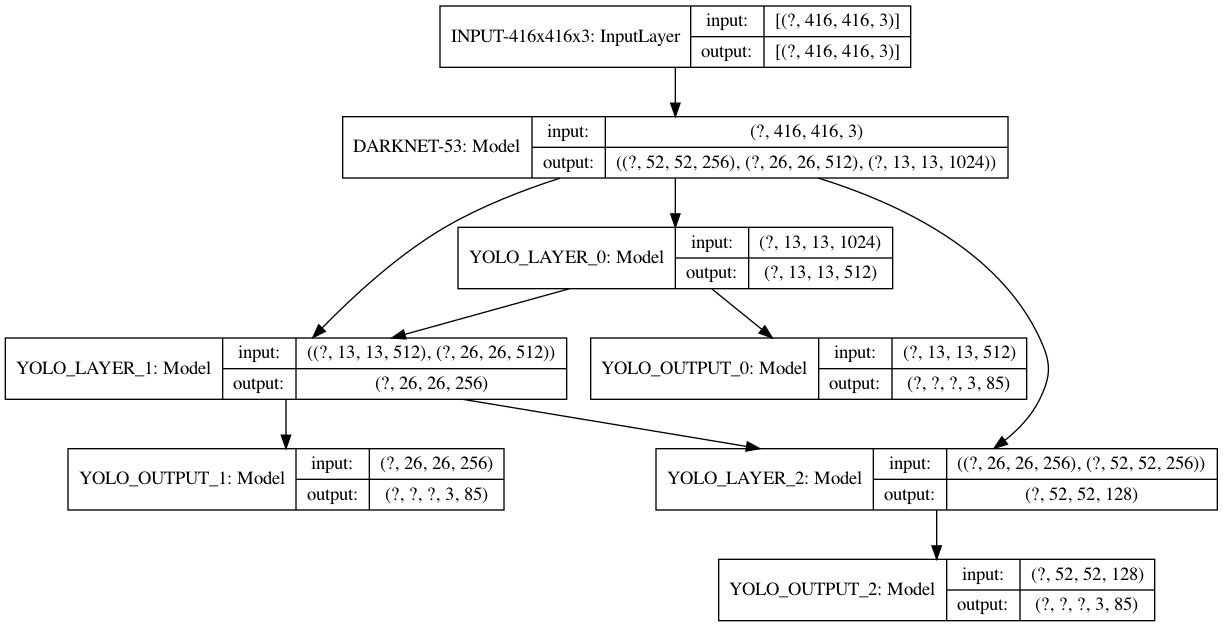

In [22]:
keras.utils.plot_model(model.yolo_V3, to_file=str(OUTPUT_DIR/"model.png"), show_shapes=True)

In [23]:
# COCO Class names
CLASS_FILE = "../Vision/yolo/coco.names"
class_names = [c.strip() for c in open(CLASS_FILE).readlines()]
class_names[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

In [24]:
import random

COLOR_LIST = ['navy', 'blue', 'aqua',
              'teal', 'olive', 'green', 
              'lime', 'yellow', 'orange',
              'red', 'maroon', 'fuchsia',
              'purple', 'black', 'gray' ,
              'silver']

id_list = list(np.arange(0, 81))

COLOR_MAPPING = {}
for idx in id_list:  COLOR_MAPPING[idx] = random.choice(COLOR_LIST)

print(COLOR_MAPPING)

{0: 'orange', 1: 'gray', 2: 'silver', 3: 'aqua', 4: 'gray', 5: 'fuchsia', 6: 'orange', 7: 'black', 8: 'blue', 9: 'navy', 10: 'maroon', 11: 'olive', 12: 'fuchsia', 13: 'teal', 14: 'purple', 15: 'blue', 16: 'aqua', 17: 'green', 18: 'lime', 19: 'blue', 20: 'aqua', 21: 'orange', 22: 'purple', 23: 'maroon', 24: 'gray', 25: 'navy', 26: 'silver', 27: 'green', 28: 'navy', 29: 'orange', 30: 'purple', 31: 'maroon', 32: 'gray', 33: 'lime', 34: 'navy', 35: 'red', 36: 'blue', 37: 'red', 38: 'orange', 39: 'yellow', 40: 'red', 41: 'teal', 42: 'black', 43: 'fuchsia', 44: 'red', 45: 'silver', 46: 'purple', 47: 'gray', 48: 'gray', 49: 'lime', 50: 'green', 51: 'blue', 52: 'yellow', 53: 'fuchsia', 54: 'black', 55: 'black', 56: 'maroon', 57: 'silver', 58: 'aqua', 59: 'green', 60: 'yellow', 61: 'maroon', 62: 'teal', 63: 'navy', 64: 'fuchsia', 65: 'silver', 66: 'green', 67: 'navy', 68: 'olive', 69: 'silver', 70: 'aqua', 71: 'silver', 72: 'navy', 73: 'olive', 74: 'red', 75: 'lime', 76: 'maroon', 77: 'black', 

In [25]:
# export
def detect(IMG_FILE:str, model, file=None, display=True, verbose=1, **kwargs):
    """
    Draws outputs on the image
    
    Arguments:
     1. image_file
     2. model [Required]
     3. file [Optional] [filepath where to save results]
     4. display [Optional] [Wether to display the Image]
     5. **kwargs [Arguments for model.predict() function] [Optional]
    """
    try:     img = cv2.imread(IMG_FILE)
    except:  img = IMG_FILE
    
    wh = np.flip(img.shape[0:2])
    im = tf.cast(img/255, tf.float32)
    im = tf.image.resize(im,size=[INPUT_SIZE,INPUT_SIZE])
    im = tf.expand_dims(im,axis=0)
    
    boxes, scores, classes, nums = model.predict(im, **kwargs)
    
    boxes, objectness, classes, nums = boxes[0], scores[0], classes[0], nums[0]
    
    if verbose >0 :print("[INFO] Number of objects detected: ", int(nums))
    
    counter = 1
    
    for i in range(nums):
        # Grab the xmin,xmax,ymin,ymax values
        x1y1 = tuple(np.array(boxes[i][0:2]*wh).astype(np.int32))
        x2y2 = tuple(np.array(boxes[i][2:4]*wh).astype(np.int32))
        
        cls_id = int(classes[i])
        
        label = class_names[cls_id] + ': {:.1f}'.format(objectness[i])
        
        bb.add(img, x1y1[0], x1y1[1], x2y2[0], x2y2[1], label=label, color=COLOR_MAPPING[cls_id])
        
        percent_comp = (counter/nums) * 100
        
        if verbose > 0:
            print('[INFO] Drawing Predicitons. Please Wait...{:.2f}% Complete'
                  .format(percent_comp),end = '\r', flush = True)
        
        counter += 1

    # display the image if output output file is not given
    if  display:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(22,22))
        plt.imshow(img)
        plt.axis("off")
        
    elif not display and file is None:
        return img
    
    # else save the image at file
    if file is not None:
        cv2.imwrite(file, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if verbose > 0: print(f"\n[INFO] Results saved at {file}")

[INFO] Number of objects detected:  19


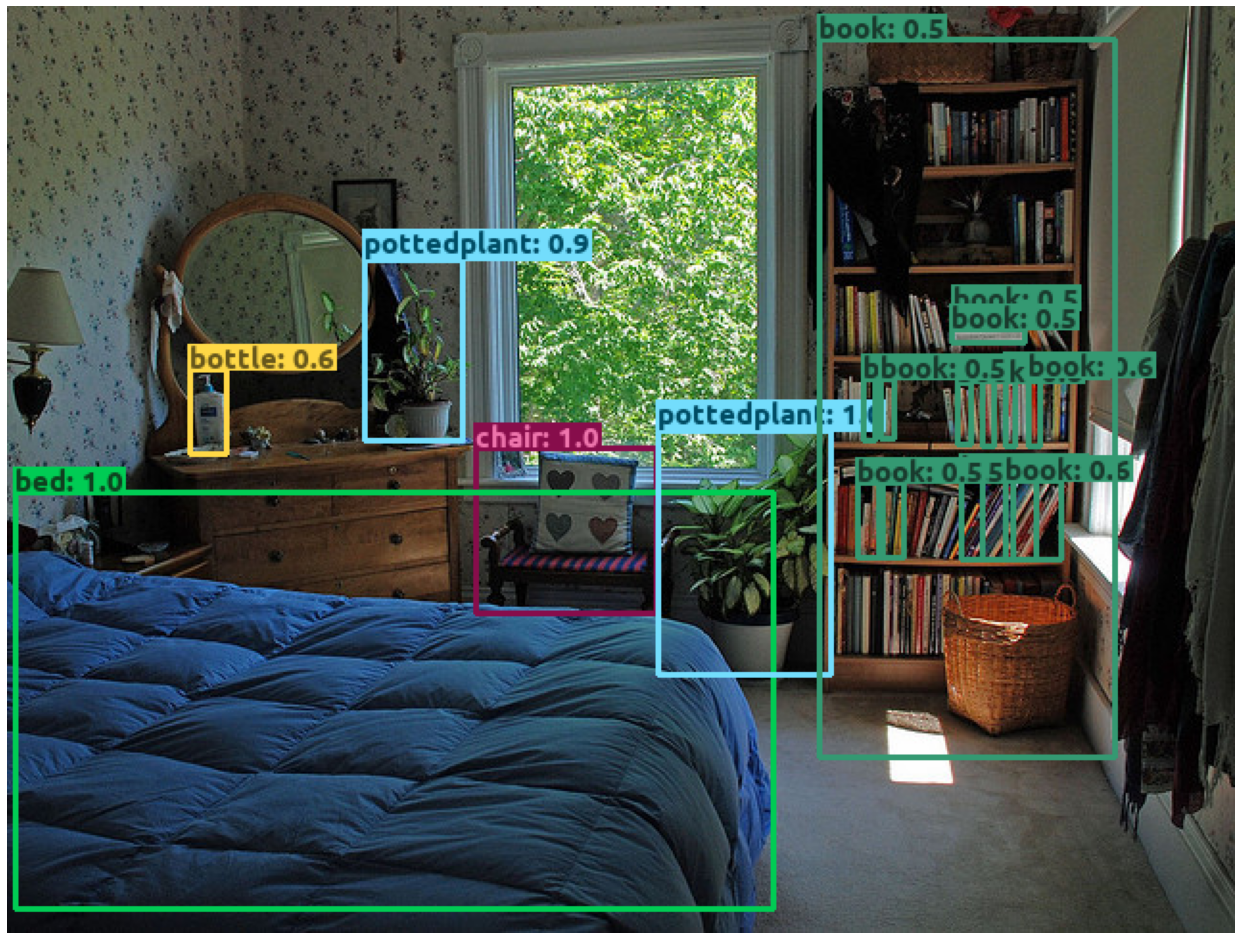

In [26]:
detect("data/val2017/000000000632.jpg", model)

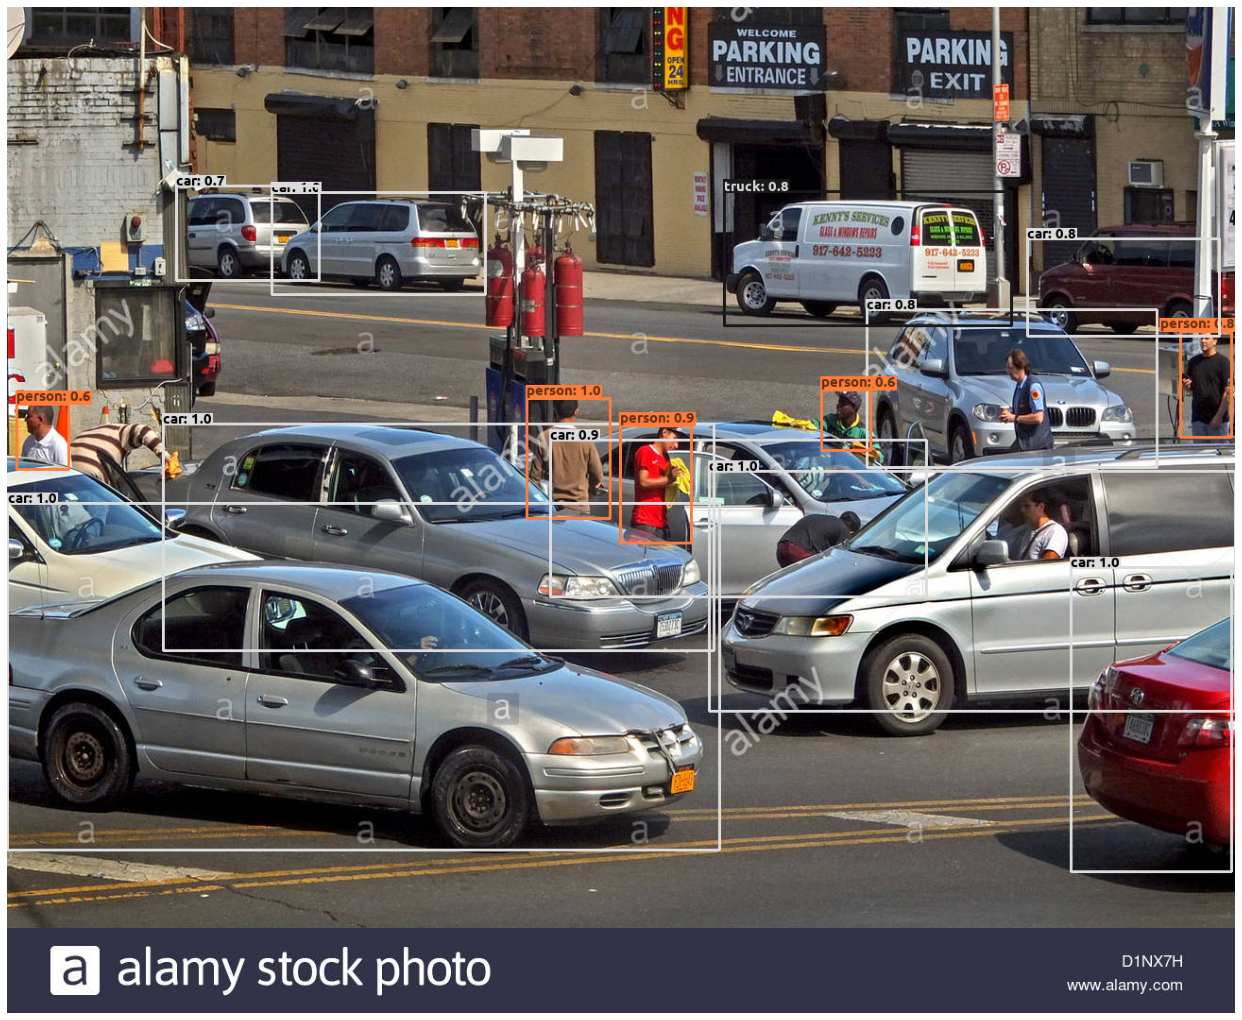

In [27]:
detect("data/car.jpg", model=model, verbose=0)

[INFO] Number of objects detected:  13


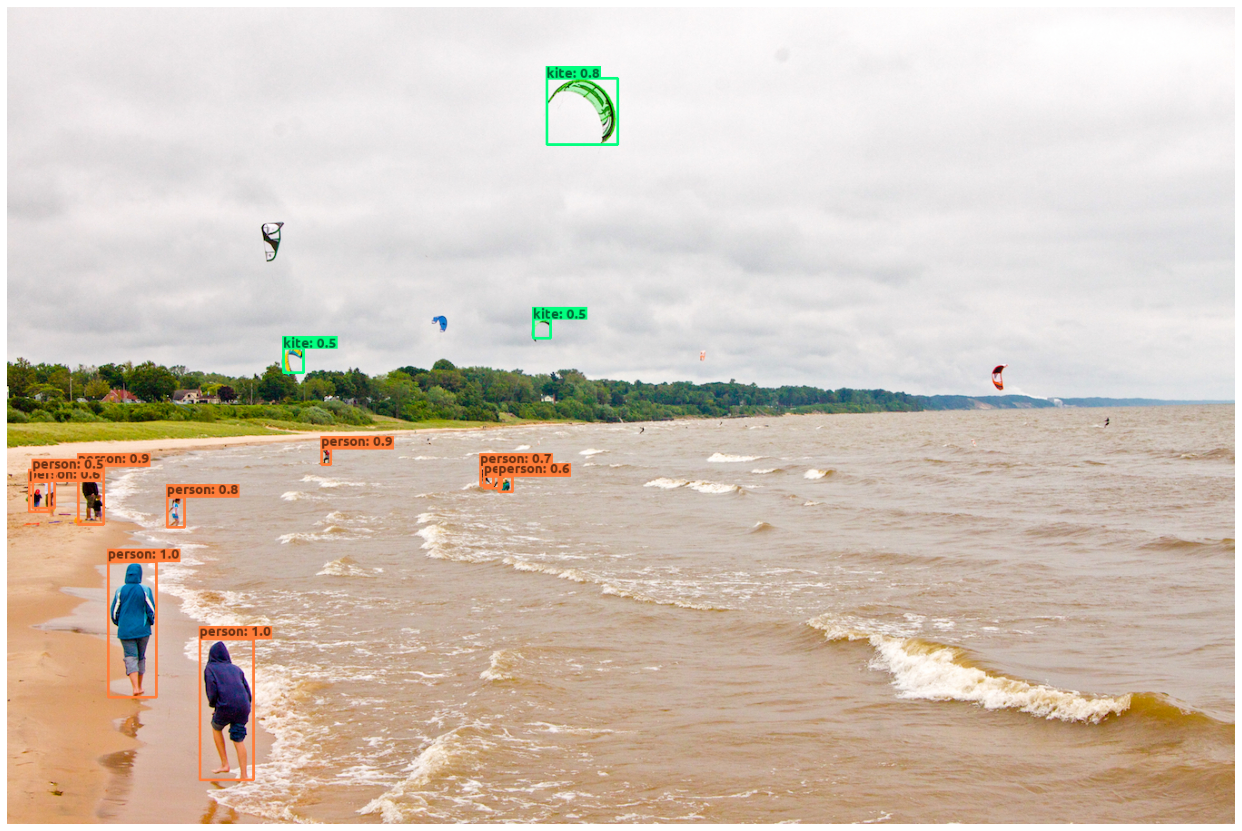

In [28]:
detect("data/image_1.jpg", model=model)

[INFO] Number of objects detected:  8
[INFO] Drawing Predicitons. Please Wait...100.00% Complete
[INFO] Results saved at outputs/result.jpg


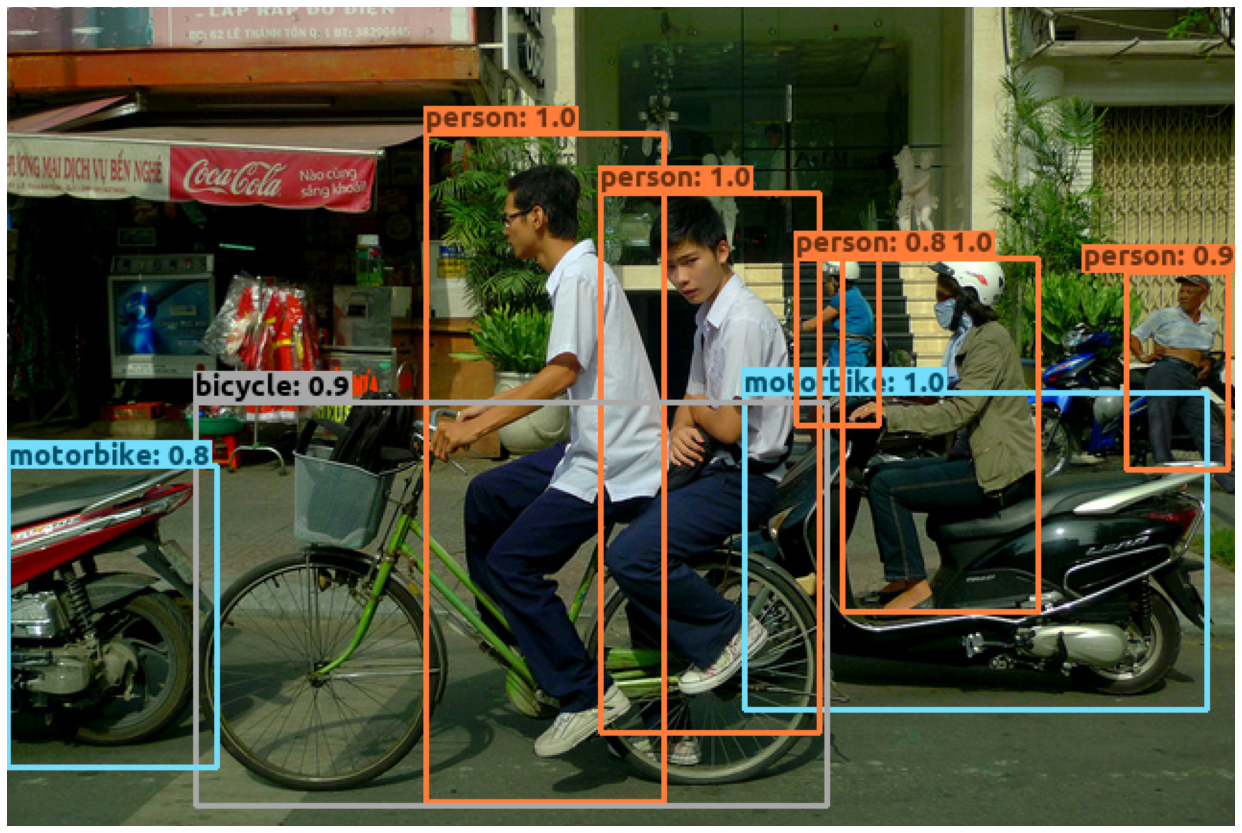

In [29]:
detect("data/val2017/000000038829.jpg", model, file="outputs/result.jpg")

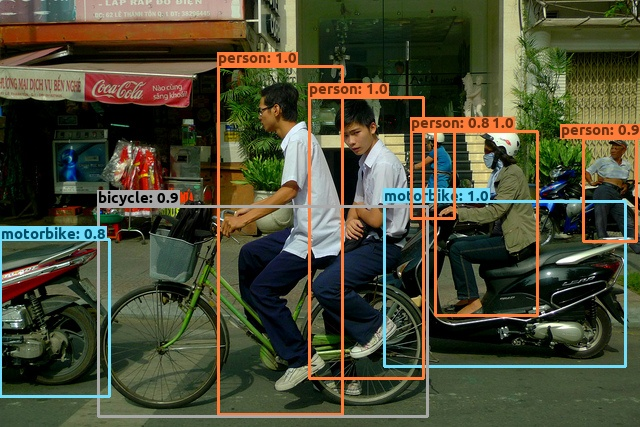

In [30]:
from IPython.display import Image
Image("outputs/result.jpg")

In [164]:
def detect_video(video:str, model, output:str, **kwargs):
    """Draw Bounding box over VideoFile"""
    # initialize the video stream, pointer to the output video file,
    # and frame dimensions
    vs = cv2.VideoCapture(video)
    writer = None
    (W,H) = (None,None)
    
    # try to determin total number of images in the frame
    try:
        prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() else cv2.CAP_PROP_FRAME_COUNT
        total = int(vs.get(prop))
        print("[INFO] {} total frames in video".format(total))
    # an error occurred while trying to determine the total
    # number of frames in the video file
    except:
        print("[INFO] could not determine # of frames in video")
        print("[INFO] no approx. completion time can be provided")
        total = -1    
    
    print('[INFO] Drawing Predicitons', end="\t")
    if total > 0: bar = tqdm(range(total), leave=False)
    # loop over frames from the video file stream
    while True:
            
        # read the next frame from the file
        (grabbed, frame) = vs.read()
        
        # if the frame was not grabbed, then we have reached the end
        # of the stream
        if not grabbed:     break
            
        # if the frame dimensions are empty, grab them
        if W is None or H is None:   (H, W) = frame.shape[:2]
            
        # Draw the bboxs on the image
        frame = detect(frame, model, display=False, **kwargs, verbose=0)
        
        # check if the video writer is None
        if writer is None:
            # initialize video writer
            fourcc = cv2.VideoWriter_fourcc(*"MP4V")
            writer = cv2.VideoWriter(output, fourcc, 30,(frame.shape[1], frame.shape[0]), True)
        
        # write the output frame to disk
        writer.write(frame)
        bar.update(1)
        
    # release the file pointers
    print("[INFO] cleaning up...")
    print(f"[INFO] output saved to {output} ... ")
    writer.release()
    vs.release()        

In [165]:
detect_video(video="outputs/crowd copy.mp4", model=model, output="outputs/crowd_yolo_res.mp4")

[INFO] 404 total frames in video
[INFO] Drawing Predicitons	

[INFO] cleaning up...
[INFO] output saved to outputs/crowd_yolo_res.mp4 ... 
